<p class='cooltitle' style="font-size:35px; text-align:center;" >The Active Membrane</p>
<br><br>

Active membrane currents are the basis of neuronal membrane excitability, they allow neurons to receive, integrate and transmit signals. One landmark in Neuroscience is considered **the Hudgkin-Huxley Model (1952)** or the conductance based model, it is a set of four beautiful nonlinear differential equations that describe how excitable cells generate action potentials.

<h1>Table of contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hudgkin-&amp;-Huxley-Model" data-toc-modified-id="Hudgkin-&amp;-Huxley-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hudgkin &amp; Huxley Model</a></span></li></ul></div>

Let's import the essential libraries for our implementation.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera  # A module that will allow us to do plotting animations
from scipy.integrate import solve_ivp  # This function will help with solving differential equations

# Hudgkin & Huxley Model


- In the case of space-clamped squid axon : 

$$\large{\color{red} {c_M \dot V = -\bar{g_{Na}}m^3h(V - E_{Na}) - \bar{g_K}n^4(V - E_K) - \bar{g_L}(V - E_L) + I_{injected}}}$$<br>
$$ \large{\color{red}  {\dot n = \phi [ \alpha_n(V)(1-n) - \beta_n(V)n]  = (n_\infty(V) - n)/\tau_n(V)}} $$<br>
$$ \large{\color{red}  {\dot m = \phi [ \alpha_m(V)(1-m) - \beta_m(V)m] = (m_\infty(V) - m)/\tau_m(V)}} $$<br>
$$ \large{\color{red}  {\dot h  = \phi [ \alpha_h(V)(1-h) - \beta_h(V)h] = (h_\infty(V) - h)/\tau_h(V)}} $$<br>

> Whereas $\phi$ is the temperature factor and : 
$$ \alpha_n(V) = 0.01(10-V)/ exp(10-V)/10) - 1) , $$<br>
$$ \beta_n(V) = 0.125exp(-V/80) , $$<br>
$$ \alpha_m(V) = 0.1(25-V)/(exp((25-V)/10) - 1) , $$<br>
$$ \beta_m(V) = 4exp(-V/18) , $$<br>
$$ \alpha_h(V) = 0.07exp(-V/20) , $$<br>
$$ \beta_h(V) = 1/(exp((30-V)/10) + 1) . $$

- Like we already saw in the Enzyme Kinetics notebook, the time and the stationary state constants for the enzymatic equilibrium for a certain protein that transforms between two conformations are : 
$$\tau = \frac{1}{\alpha+\beta}, f_\infty = \frac{\alpha}{\alpha+\beta}$$


- Simulating the Hudgkin & Huxley model is all about solving a set of four differential equations, as you may have seen, analytically solving those equations maybe a hard task, so we will resolve to numerically solving them starting from initial conditions for our 4 variables : $V$, $n$, $m$, $h$ and for a given period of time $t$.
 
<br>

- What we're going to do now is create a python class named Neuron, this class will behave like a Hudgkin & Huxley Model and we will be able to see its properties and all its constants for a range of voltage values, also we will be able to simulate this model starting from some initial conditions that we choose like the injected current or the membrane voltage.


In [34]:
class Neuron():
    """Hudgkin & Huxley Model of the excitable cell"""
    def __init__(self, voltage, sodium, potassium, leak):
        """This instantiates a Neuron object with the following properties
        sodium, potassium and leak should be dictionaries with their conductance
        and equilibrium potential as elements.
        """
        self.voltage = voltage
        self.Gna, self.Ena = sodium['G'], sodium['Eq']
        self.Gk, self.Ek = potassium['G'], potassium['Eq']
        self.Gl, self.El = leak['G'], leak['Eq']

    def __str__(self):
        """This lets the Neuron Object be used by the print() function"""
        return "Hello ! I'm Hudgkin & Huxley Model"

    def an(self, volt):
        """alpha_n in function of voltage, potassium channel constant"""
        return 0.01 * (10 - volt) / (np.exp((10. - volt) / 10.) - 1.)

    def bn(self, volt):
        """beta_n in function of voltage, potassium channel constant"""
        return 0.125 * np.exp(-volt / 80.)

    def am(self, volt):
        """alpha_m in function of voltage, sodium channel constant"""
        return 0.1 * (25. - volt) / (np.exp((25. - volt) / 10.) - 1.)

    def bm(self, volt):
        """beta_m in function of voltage, sodium channel constant"""
        return 4. * np.exp(-volt / 18.)

    def ah(self, volt):
        """alpha_h in function of voltage, sodium channel constant"""
        return 0.07 * np.exp(-volt / 20.)

    def bh(self, volt):
        """beta_h in function of voltage, sodium channel constant"""
        return 1. / (np.exp((30. - volt) / 10.) + 1.)

    def tau(self, alpha, beta):
        """this method calculates the time constant tau 
        for a certain ion channel.
        """
        return 1. / (alpha + beta)

    def finfty(self, alpha, beta):
        """this method calculates the stationary constant
        f_infty for a certain ion channel.
        """
        return alpha / (alpha + beta)

    def INa(self):
        """this calculates the sodium transient current using previous class methods."""
        m = self.finfty(self.am(self.voltage), self.bm(self.voltage))
        h = self.finfty(self.ah(self.voltage), self.bh(self.voltage))

        return self.Gna * m**3. * h * (
            self.voltage - self.Ena
        )  # Ohm's law for ion channels I = G*(V - Eeq)

    def IK(self):
        """this calculates the potassium persistant current using previous class methods."""
        n = self.finfty(self.an(self.voltage), self.bn(self.voltage))

        return self.Gk * n**4. * (
            self.voltage - self.Ek
        )  # Ohm's law for ion channels I = G*(V - Eeq)

    def IL(self):
        """this calculates the leak channel current."""
        return self.Gl * (self.voltage - self.El)

    def time_constants(self):
        """This method creates an animation for the time constants
        of our model for a given array of voltages.
        """
        tn = self.tau(self.an(self.voltage), self.bn(self.voltage))
        tm = self.tau(self.am(self.voltage), self.bm(self.voltage))
        th = self.tau(self.ah(self.voltage), self.bh(self.voltage))
        fig, ax = plt.subplots(dpi=150)
        cam1 = Camera(fig)
        for s in range(len(
                self.voltage)):  # For loop to create the plotting animation

            t1, t2, t3 = plt.plot(self.voltage[:s],
                                  tm[:s],
                                  'r',
                                  self.voltage[:s],
                                  th[:s],
                                  'b',
                                  self.voltage[:s],
                                  tn[:s],
                                  'y',
                                  linestyle='solid')
            plt.legend([t1, t2, t3], [r'$\tau_m$', r'$\tau_h$', r'$\tau_n$'])
            plt.suptitle("Time constants for ion channel kinetics")
            plt.xlabel("Voltage in mV")
            cam1.snap()
        cam1.animate(blit=False, interval=50, repeat=True).save('tau.mp4')

    def stationary_constants(self):
        """This method creates an animation for the stationary constants
        of our model for a given array of voltages.
        """
        fn = self.finfty(self.an(self.voltage), self.bn(self.voltage))
        fm = self.finfty(self.am(self.voltage), self.bm(self.voltage))
        fh = self.finfty(self.ah(self.voltage), self.bh(self.voltage))
        fig, ax = plt.subplots(dpi=150)
        cam2 = Camera(fig)
        for s in range(len(self.voltage)):
            f1, f2, f3 = plt.plot(self.voltage[:s], fm[:s], 'r',
                                  self.voltage[:s], fh[:s], 'b',
                                  self.voltage[:s], fn[:s], 'y')
            plt.legend([f1, f2, f3],
                       [r'$m\infty$', r'$h\infty$', r'$n\infty$'])
            plt.suptitle("Stationary constants for ion channel kinetics")
            plt.xlabel("Voltage in mV")
            cam2.snap()
        cam2.animate(blit=False, interval=50, repeat=True).save('f_infty.mp4')

    def show_currents(self):
        """This method creates an animation for the 3 currents in our model
        calculated based on a given array of voltages.
        """

        fig, ax = plt.subplots(dpi=150)
        cam3 = Camera(fig)
        for s in range(len(self.voltage)):
            i1, i2, i3 = plt.plot(self.voltage[:s],
                                  self.IK()[:s], 'r', self.voltage[:s],
                                  self.INa()[:s], 'g', self.voltage[:s],
                                  self.IL()[:s], 'b')
            plt.legend([i1, i2, i3], [r'$I_{K^+}$', r'$I_{Na^+}$', r'$I_{L}$'])

            plt.ylim(-200, 500)
            plt.xlabel("Voltage in mV")
            plt.ylabel('Current in mA')
            plt.suptitle("$I-V$ curves in Hudgkin and Huxley Model")
            cam3.snap()
        cam3.animate(blit=False, interval=50, repeat=True).save('currents.mp4')

    def simulate(self, V_init, n_init, m_init, h_init, Tmax, inj=0):
        """This method simulates the H&H model starting from initial conditions
        given as parameters for a given period of time Tmax, it uses scipy.integrate.solve_ivp()
        function to solve the system of four differential equations.
        """
        def hudgkin_huxley(t, vars):
            """The four nonlinear differential equations should be wrapped inside a function."""
            V, n, m, h = vars
            return [
                -self.Gna * m**3 * h * (V - self.Ena) - self.Gk * n**4 *
                (V - self.Ek) - self.Gl * (V - self.El) + inj,
                (self.an(V) * (1 - n)) - (self.bn(V) * n),
                (self.am(V) * (1 - m)) - (self.bm(V) * m),
                (self.ah(V) * (1 - h)) - (self.bh(V) * h)
            ]

        solution = solve_ivp(
            hudgkin_huxley,
            [0, Tmax],  # Solve the system 
            (V_init, n_init, m_init, h_init),  # Initial conditions as a tuple
            t_eval=np.linspace(0, Tmax, 250))

        tt, vt, nt, mt, ht = solution.t, solution.y[0], solution.y[
            1], solution.y[2], solution.y[3]  # Seperate the solutions

        # Now let's calculate currents and conductances based on the solutions
        GNA, INA = self.Gna * mt**3 * ht, self.Gna * mt**3 * ht * (vt -
                                                                   self.Ena)
        GK, IK = self.Gk * nt**4, self.Gk * nt**4 * (vt - self.Ek)
        IL = self.Gl * (vt - self.El)

        # Now let's start the plotting and the animation process
        fig, axes = plt.subplots(1, 3, figsize=(12, 5), dpi=150)
        cam4 = Camera(fig)
        for s in range(len(vt)):
            l1, = axes[0].plot(tt[:s], vt[:s], 'g', linestyle='solid')
            axes[0].legend([l1], [r'$V(t)$'])  # V(t) in function of time

            i1, i2, i3 = axes[1].plot(
                tt[:s],
                INA[:s],
                'y',
                tt[:s],
                IK[:s],
                'r',
                tt[:s],
                IL[:s],
                'b',
                linestyle='solid')  # Currents in fucntion of time
            axes[1].set_xlabel('Time')
            axes[1].legend([i1, i2, i3],
                           [r'$I_{Na^+}$', r'$I_{K^+}$', r'$I_{L}$'])
            axes[1].set_title("""Hudgkin & Huxley Model Simulation,
                Initial conditions : $V$ = %s, $n$ = %s, $m$ = %s, $h$ = %s, $T_{max}$ = %s, $I_{injected}$ = %s"""
                              % (V_init, n_init, m_init, h_init, Tmax, inj))

            g1, g2 = axes[2].plot(
                tt[:s], GNA[:s], 'y', tt[:s], GK[:s], 'r',
                linestyle='solid')  # Conductances in function of time
            axes[2].legend([g1, g2], [r'$g_{Na^+}$', r'$g_{K^+}$'])
            cam4.snap()
        cam4.animate(blit=False, interval=30,
                     repeat=True).save('HHsimulation.mp4')

> Now that we've written our Python Class, we can start using it. Let's take some values for our ions.

In [35]:
# Conductance in mS.cm^-2 and equilibrium potential in mV, 
Na = {'G' : 120., 'Eq' : 120.}
K = {'G' : 36., 'Eq' : -12.}
Leak = {'G' : 0.3,'Eq' :10.6}

> Let's also take values for our voltage between -150 and +150 mV

In [36]:
v = np.linspace(-150, 150, 100)

> And now we can create a class instance (object) of our Neuron Class : 

In [37]:
cell = Neuron(voltage=v, sodium=Na, potassium=K, leak=Leak)

**Time constants $\tau$ and stationary constants $f_\infty$** <br>
> Let's take a look at our model's time constants for each channel.

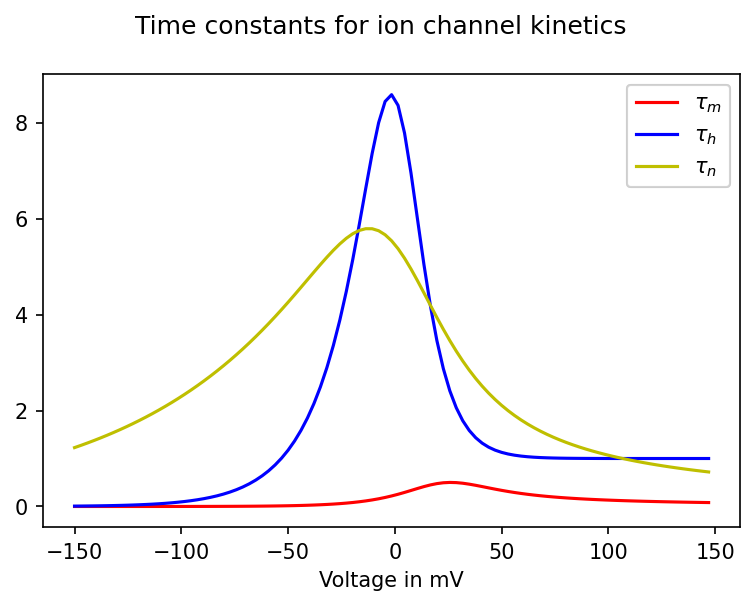

In [11]:
cell.time_constants()

> and here's the stationary constants for our ion channels.

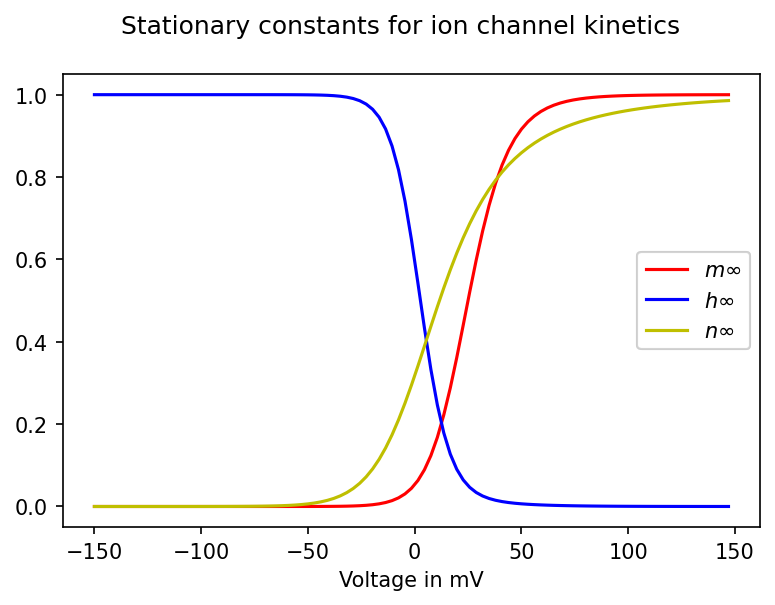

In [12]:
cell.stationary_constants()

**The currents of the model**
> Now let's see our 3 major currents for a range of voltages.

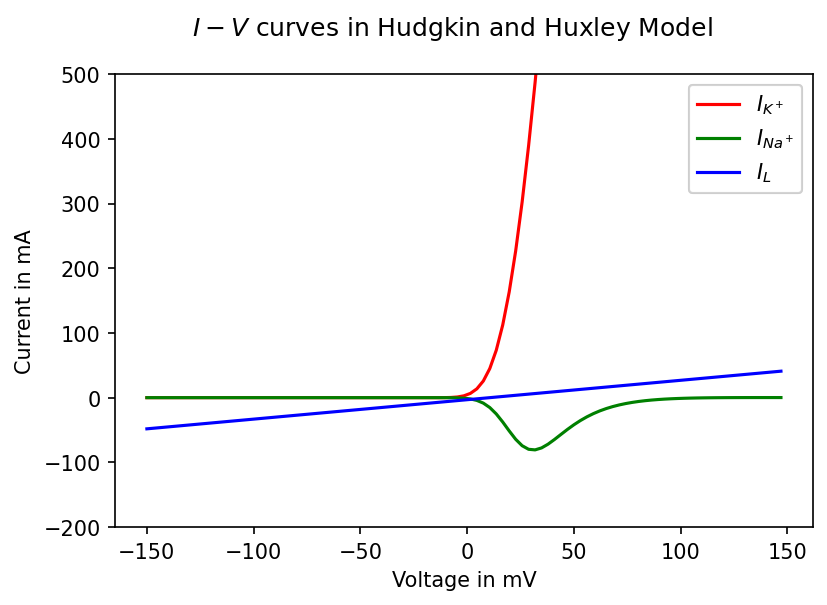

In [13]:
cell.show_currents()

**Model simulation**

> And finally, we can simulate our model starting from chosen initial conditions like the voltage or the even the injected current. Let's inject a current of amplitude 15 and start from a voltage of -10 and see what happens over the course of 60 ms. ($n$ and $m$ are 0 and $h$ is 1 and $T_{max} = 50$)

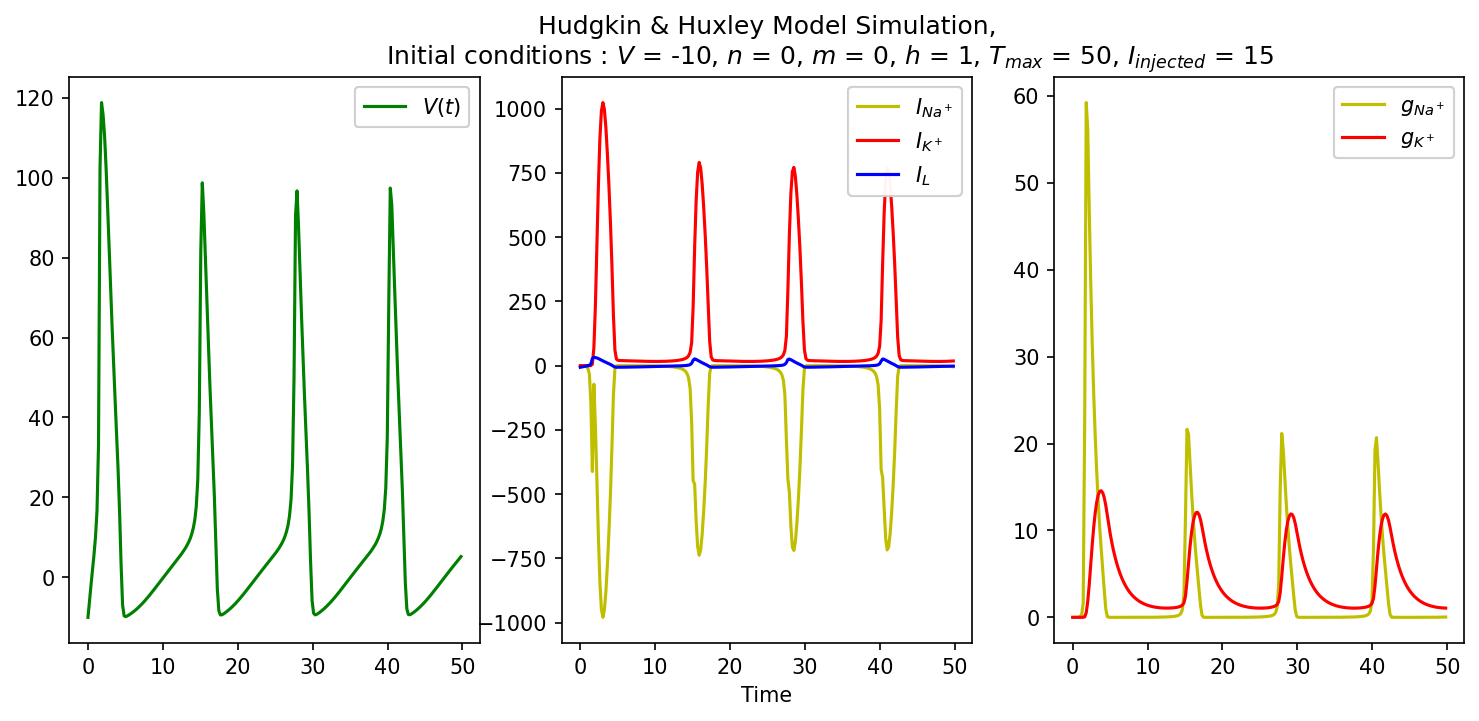

In [39]:
cell.simulate(V_init=-10, n_init=0, m_init=0, h_init=1, Tmax=50, inj = 15)

<hr class="sep">